In [1]:
import numpy as np
import sys 

from autoencoder_v3 import loading_coef,encoder_forward,encoder_derivative
from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from sympy.physics.mechanics import *
from sympy import *
from numpy import sin, cos, tan, cosh, tanh, sinh
from torch.autograd import Variable
import sympy
import torch
import sys
import HLsearch as HL
import example_pendulum
import time
import matplotlib.pyplot as plt


3.373141386234365e-69


In [2]:
device = 'cuda:0'
data = example_pendulum.get_pendulum_data(40)

In [3]:
num_sample = 100
training = True
save = False
noiselevel = 2e-2
file_route = R'C:\Users\87106\OneDrive\sindy\progress\AE'
load_date = '3-20'
load_ver = 1
widths = [1024,512,128]
params={}
params['ver'] = 1
params['date'] = '3-22'
params['widths'] = widths
params['activation'] = 'sigmoid'
params['batch_size'] = 64
params['learning_rate'] = 1e-5
params['learning_rate_stage2'] = 1e-6
params['threshold'] = 0.2
params['num_epochs'] = 6000
params['sample_frequency'] = 20
params = loading_coef(params,load_date,load_ver,file_route,device)
image = torch.from_numpy(data['x']).to(torch.float32).to(device)
image_t = torch.from_numpy(data['dx']).to(torch.float32).to(device)
image_tt = torch.from_numpy(data['ddx']).to(torch.float32).to(device)
x = encoder_forward(image,params)
#x = x.clone().detach().requires_grad_(True)
x = x.cpu().detach().numpy()
dx,ddx = encoder_derivative(image,image_t,image_tt,params)
#dx = dx.clone().detach().requires_grad_(True) 
#ddx = ddx.clone().detach().requires_grad_(True)  
dx = dx.cpu().detach().numpy()
ddx = ddx.cpu().detach().numpy()
X = []
Xdot = []
loss_history = []
t = len(x)


loading params
torch.Size([2601, 1024])
torch.Size([1024, 512])
torch.Size([512, 128])
torch.Size([128, 1])
torch.Size([1024])
torch.Size([512])
torch.Size([128])
torch.Size([1])
torch.Size([1, 128])
torch.Size([128, 512])
torch.Size([512, 1024])
torch.Size([1024, 2601])
torch.Size([128])
torch.Size([512])
torch.Size([1024])
torch.Size([2601])


In [4]:
#adding noise
#not modified yet
"""
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise
"""

'\nmu, sigma = 0, noiselevel\nnoise = np.random.normal(mu, sigma, X.shape[0])\nfor i in range(X.shape[1]):\n    X[:,i] = X[:,i]+noise\n    Xdot[:,i] = Xdot[:,i]+noise\n'

In [5]:
states_dim = 2
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

states are: (x0, x0_t)
states derivatives are:  (x0_t, x0_tt)


In [6]:
#build function expression for the library in str
expr= HL.buildFunctionExpressions(2,states_dim,states,use_sine=True)
#expr=['x0', 'x0_t', 'sin(x0)', 'cos(x0)', 'x0**2', 'x0*x0_t', 
#'x0_t**2', 'x0*sin(x0)', 'x0_t*sin(x0)', 'sin(x0)**2', 
#'x0*cos(x0)', 'x0_t*cos(x0)', 'sin(x0)*cos(x0)', 'cos(x0)**2']
#expr=['cos(x0)','x0_t**2']
"a list of candidate function"
print(expr)
coef = torch.ones(len(expr), device=device).data.uniform_(-10,10)
coef = Variable(coef,requires_grad=True)

['x0', 'x0_t', 'sin(x0)', 'cos(x0)', 'x0**2', 'x0*x0_t', 'x0_t**2', 'x0*sin(x0)', 'x0_t*sin(x0)', 'sin(x0)**2', 'x0*cos(x0)', 'x0_t*cos(x0)', 'sin(x0)*cos(x0)', 'cos(x0)**2']


In [7]:
#TBD
#time derivative of the expressions
expr_dot = ['x0_t','x0_tt','x0_t*cos(x0)','-x0_t*cos(x0)','2*x0_t*x0',
           'x0_t**2+x0*x0_tt','2*x0_t*x0_tt','x0_t*sin(x0)+x0*x0_t*cos(x0)',
           'x0_tt*sin(x0)+cos(x0)*x0_t**2','2*x0_t*sin(x0)*cos(x0)',
           'x0_t*cos(x0)-x0*x0_t*sin(x0)','x0_tt*cos(x0)-sin(x0)*x0_t**2',
           'x0_t*cos(x0)**2-x0_t*sin(x0)**2','-2*x0_t*sin(x0)*cos(x0)']

In [8]:
#load the latent variables and calculate the expressions
expr_val = torch.ones(len(expr),t,device=device)
expr_dot_val = torch.ones(len(expr),t,device=device)
locals()[states[0]] = x
locals()[states[1]] = dx
locals()[states_dot[0]] = dx
locals()[states_dot[1]] = ddx
print(eval(str(expr[2])))
for n in range(len(expr)):
    temp = eval(str(expr[n]))
    temp = torch.tensor(temp,dtype=torch.float32,device=device)
    for i,j in enumerate(temp):
        expr_val[n,i] = j
    temp = eval(str(expr_dot[n]))
    temp = torch.tensor(temp,dtype=torch.float32,device=device)
    for i,j in enumerate(temp):
        expr_dot_val[n,i] = j
        



[[-0.00600543]
 [-0.00739347]
 [-0.00909286]
 ...
 [-0.00613846]
 [-0.00636162]
 [-0.0066849 ]]


In [9]:
def training_loop(coef,t,expr_val,expr_dot_val,params):
    coef.requires_grad_(True)
    loss_list = []
    training_set_size = t
    batch_size = params['batch_size']
    opt = torch.optim.Adam([coef], lr=params['learning_rate'])
    for i in range(training_set_size//batch_size):
        expr_dot_val_batch = expr_dot_val[:,i*batch_size:(i+1)*batch_size]
        loss = torch.mean(torch.abs(torch.matmul(coef,expr_dot_val_batch))) + 0.3*torch.mean(coef)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_list.append(loss.item())
    return coef,torch.tensor(loss_list).mean().item()
        



Epoch:  0
Average loss :  73.18309020996094
expression:
-2.0216768*x0 + 0.3361704*x0_t + -9.504007*sin(x0) + 8.798531*cos(x0) + 8.914228*x0**2 + 5.9320245*x0*x0_t + -1.7008923*x0_t**2 + 6.4022427*x0*sin(x0) + -5.422165*x0_t*sin(x0) + 8.188752*sin(x0)**2 + -7.6359406*x0*cos(x0) + -8.492968*x0_t*cos(x0) + -1.8181864*sin(x0)*cos(x0) + 9.198322*cos(x0)**2 + 
number of candidates:  14


Epoch:  20
Average loss :  72.48981475830078
expression:
-2.073807*x0 + 0.38791016*x0_t + -9.556307*sin(x0) + 8.737398*cos(x0) + 8.857153*x0**2 + 5.8800206*x0*x0_t + -1.7243861*x0_t**2 + 6.3443165*x0*sin(x0) + -5.4828186*x0_t*sin(x0) + 8.128821*sin(x0)**2 + -7.6894317*x0*cos(x0) + -8.441278*x0_t*cos(x0) + -1.8703332*sin(x0)*cos(x0) + 9.137791*cos(x0)**2 + 
number of candidates:  14


Epoch:  40
Average loss :  71.79654693603516
expression:
-2.1258898*x0 + 0.43964806*x0_t + -9.608549*sin(x0) + 8.676201*cos(x0) + 8.799994*x0**2 + 5.8280168*x0*x0_t + -1.7478536*x0_t**2 + 6.2863526*x0*sin(x0) + -5.543477*x0_t*

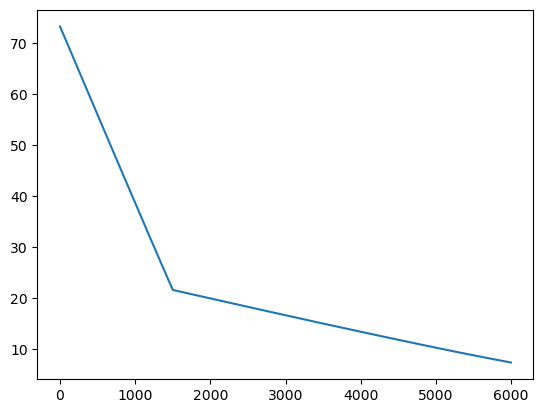

In [10]:
for epoch in range(params['num_epochs']):
    coef, loss = training_loop(coef,t,expr_val,expr_dot_val,params)
    loss_history.append(loss)
    if epoch >= 1500:
        params['learning_rate'] =  params['learning_rate_stage2']
    if epoch % params['sample_frequency'] == 0:
        print("\n")
        print("Epoch: ", epoch)
        print("Average loss : " , loss)
        print("expression:")
        print(HL.generateExpression(coef.cpu().detach().numpy(),expr))
        print("number of candidates: ", len(expr))
    survive_index = ((torch.abs(coef) >= params['threshold']).nonzero(as_tuple=True)[0]).detach().cpu().numpy()
    expr = np.array(expr)[survive_index].tolist()
    coef = coef[survive_index].clone().detach()
    expr_val = expr_val[survive_index,:].clone().detach()
    expr_dot_val = expr_dot_val[survive_index,:].clone().detach()
plt.plot(loss_history)
